# General Setup

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

from pyCascade import probePost, physics, quantities
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


In [5]:
############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

# Run

In [6]:
category =  "config2"
run = 52
theta = 45
thetaRad = theta/180 * np.pi

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'
oak_probes_dir =  f'{home_dir}/CHARLES/{category}/R{run}/probes/probesOut_parquet/'

# Volume Probes

In [35]:
qoisOutputed = ["mag(u)_avg", "mag(u)_rms", "comp(u_rms,0)", "comp(u_rms,1)", "comp(u_rms,2)", "comp(u_avg,0)", "comp(u_avg,1)", "comp(u_avg,2)"]
probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, file_type = "csv", probe_type = "VOLUMETRIC_PROBES", flux_quants = qoisOutputed, name_pattern="VolProbe")

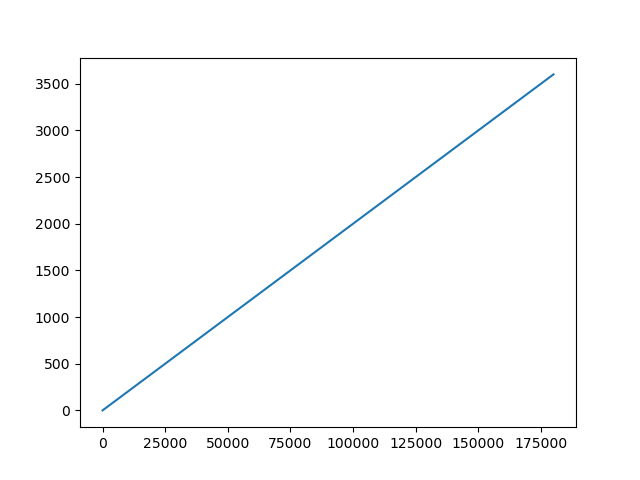

In [36]:
start = 40000
stop = 110000
# stop = 119000
# start = 160000
# stop = 240000
by = 1

plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)

In [37]:
stats = probes.statistics(
    names = [name for name in  probes.probe_names if "VolProbe" in name], 
    steps = [stop],
    quants = qoisOutputed,
    processing = None,
    parrallel=False
)
stats

processing data took 30 seconds


,"comp(u_avg,0)","comp(u_avg,1)","comp(u_avg,2)","comp(u_rms,0)","comp(u_rms,1)","comp(u_rms,2)",mag(u)_avg,mag(u)_rms
VolProbe0_0-0,0.483372,-0.011087,0.274960,0.399823,0.197435,0.357571,0.862297,0.363652
VolProbe0_0-1,0.425699,-0.009961,0.260455,0.444139,0.235246,0.415253,0.894488,0.389291
VolProbe0_0-2,0.236916,-0.008634,0.513958,0.396337,0.221115,0.437981,0.922629,0.389518
VolProbe0_0-3,0.142259,-0.001846,0.515097,0.301326,0.169949,0.355306,0.785738,0.327169
VolProbe0_1-0,0.345530,0.000124,0.163846,0.339029,0.166550,0.303235,0.684165,0.300962
...,...,...,...,...,...,...,...,...
VolProbe9_2-3,1.619806,-0.061119,1.615634,0.477213,0.356216,0.464709,2.358464,0.513564
VolProbe9_3-0,1.671381,-0.052071,1.562288,0.478276,0.363343,0.487722,2.362048,0.527846
VolProbe9_3-1,1.423171,-0.025065,1.672154,0.484539,0.368702,0.461663,2.271642,0.509072
VolProbe9_3-2,0.900389,0.091440,1.136798,0.409452,0.308016,0.416928,1.548102,0.438088


In [38]:
def processVolProbeNames(s, pos = None):
    # Filter out any characters that are not digits, a decimal point, or a negative sign
    filtered = ''.join(c for c in s if c.isdigit() or c == '.' or c == '_')
    filtered = filtered.split('_')
    
    # Convert the filtered string to float
    if filtered:
        if pos is not None:
            return float(filtered[1][pos])
        else:
            return float(''.join(filtered[0]))

stats["lowerBound"] = stats.index.map(lambda s: processVolProbeNames(s))
stats["xPos"] = stats.index.map(lambda s: processVolProbeNames(s, pos=0))
stats["zPos"] = stats.index.map(lambda s: processVolProbeNames(s, pos=1))
stats.sort_values(by = ["xPos", "zPos", "lowerBound"], inplace=True)

stats["upperBound"] = stats["lowerBound"].copy()
maxBound = np.max(stats["upperBound"])
for i in range(stats.shape[0]):
    if stats["upperBound"].iloc[i] == maxBound:
        if category == "config2":
            stats["upperBound"].iloc[i] = 77.3
        elif category == "config3":
            stats["upperBound"].iloc[i] = 116
        else:
            raise Exception("Configuration {category} not an option")
    else:
        stats["upperBound"].iloc[i] = stats["lowerBound"].iloc[i+1]
stats.dropna(inplace=True)
stats["y"] = (stats["lowerBound"] + stats["upperBound"]) / 2
stats

,"comp(u_avg,0)","comp(u_avg,1)","comp(u_avg,2)","comp(u_rms,0)","comp(u_rms,1)","comp(u_rms,2)",mag(u)_avg,mag(u)_rms,lowerBound,xPos,zPos,upperBound,y
VolProbe0_0-0,0.483372,-0.011087,0.274960,0.399823,0.197435,0.357571,0.862297,0.363652,0.0,0.0,0.0,1.0,0.50
VolProbe1_0-0,0.557302,-0.011745,0.395221,0.384439,0.288305,0.347020,0.938442,0.374147,1.0,0.0,0.0,2.0,1.50
VolProbe2_0-0,0.614231,-0.010409,0.441514,0.395066,0.325325,0.360133,1.004341,0.389325,2.0,0.0,0.0,3.0,2.50
VolProbe3_0-0,0.720539,0.009814,0.530615,0.428039,0.346957,0.394632,1.119703,0.421422,3.0,0.0,0.0,4.0,3.50
VolProbe4_0-0,0.851265,0.008322,0.664797,0.454885,0.348785,0.416067,1.266083,0.453118,4.0,0.0,0.0,5.0,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
VolProbe52_3-3,1.587869,0.056312,1.838449,0.319342,0.200158,0.257524,2.452988,0.322338,52.0,3.0,3.0,56.0,54.00
VolProbe56_3-3,1.636765,0.042210,1.861078,0.326569,0.196364,0.250898,2.501655,0.317392,56.0,3.0,3.0,60.0,58.00
VolProbe60_3-3,1.716359,0.024772,1.902859,0.331117,0.187640,0.255860,2.585138,0.314590,60.0,3.0,3.0,64.0,62.00
VolProbe64_3-3,1.761758,0.023971,1.928571,0.333907,0.177205,0.258434,2.632658,0.325114,64.0,3.0,3.0,69.0,66.50


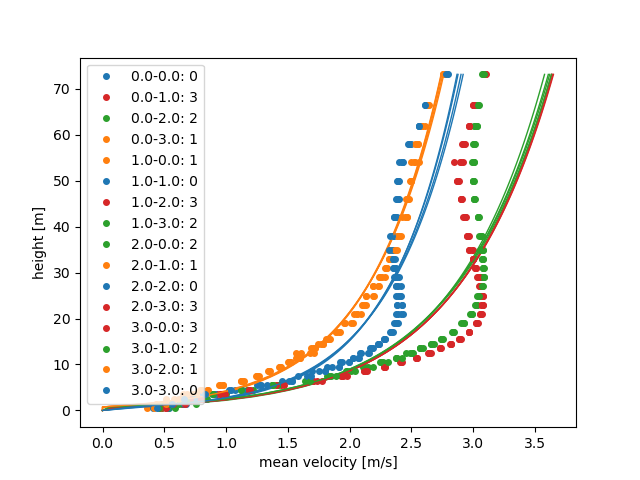

In [39]:
fig, ax = plt.subplots()
statsMI = stats.set_index(["xPos", "zPos", "y"])
c = 0
for xPos, dfx in statsMI.groupby(level=0):
    for zPos, df in dfx.groupby(level=1):
        qty_vol = quantities.Qty()
        meanU = np.sin(thetaRad) * df["comp(u_avg,0)"] + np.cos(thetaRad) * df["comp(u_avg,2)"]
        qty_vol.meanU = meanU#.iloc[6:27]
        qty_vol.y = df.index.get_level_values(2).values#[6:27]
        id = int((xPos-zPos)%4)
        ax = quantities.plot_ABL({f"{xPos}-{zPos}: {id}": qty_vol}, fit_disp=False, colorOffset=id, ax=ax)
        c += 1

## Probe Columns

In [7]:
qois = ['comp(u,0)', 'comp(u,2)']

probes = probePost.Probes(probes_dir, directory_parquet=oak_probes_dir, file_type = "csv")
# probes.to_parquet(overwrite=True)

# probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, file_type = "parquet")

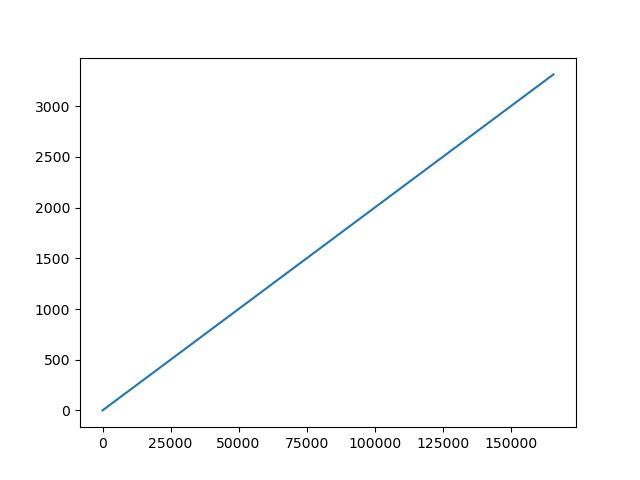

In [8]:
start = 40000
stop = 120000
by = 1

plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)

## Plot ABL

In [9]:
qty_dict = probes.create_qty_dict(
    theta_wind = theta,
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    stack = range(1,40),
)

for k, v in qty_dict.items(): v.calc_stats()

processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros
processing data took 4 seconds
pressure data not founnd, replacing with zeros


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

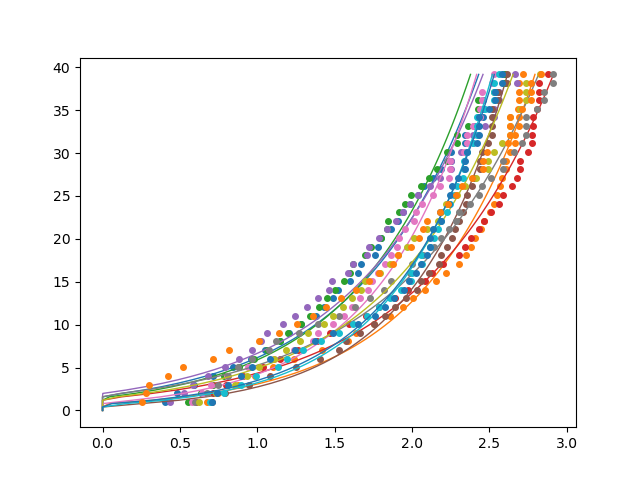

In [10]:
quantities.plot_ABL(qty_dict, fit_disp=True)


averaged: u* = 0.28043505759101045, z0 = 0.5717282351552007, disp = 0.0


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='mean velocity [m/s]', ylabel='height [m]'>)

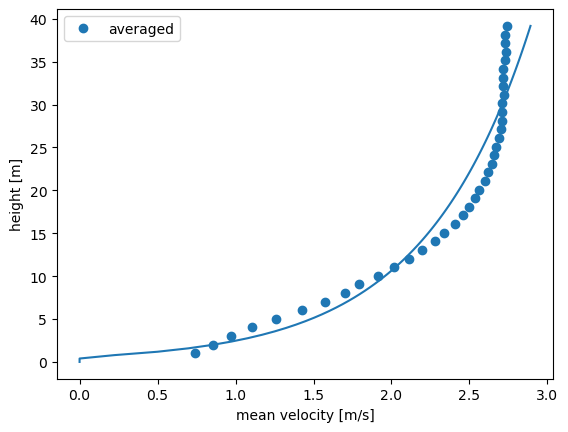

In [ ]:
qty_total = quantities.Qty()
for i, (k, v) in enumerate(qty_dict.items()):
    if i == 0:
        qty_total.meanU = np.zeros_like(v.meanU)
        qty_total.y = v.y
    qty_total.meanU += v.meanU
qty_total.meanU /= len(qty_dict)

quantities.plot_ABL({"averaged": qty_total}, fit_disp=True)

## Plot Length Scales

In [11]:
for k, v in qty_dict.items(): v.calc_scales()
quantities.plot_length_scales(qty_dict)

: 

: 

## Plot Reynolds stresses

(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': 'uu'}, ylabel='y [m]'>,
         <Axes: title={'center': 'vv'}>, <Axes: title={'center': 'ww'}>],
        [<Axes: title={'center': 'uv'}, ylabel='y [m]'>,
         <Axes: title={'center': 'uw'}, xlabel='Reynolds Stress [m^2/s^2]'>,
         <Axes: title={'center': 'vw'}>]], dtype=object))

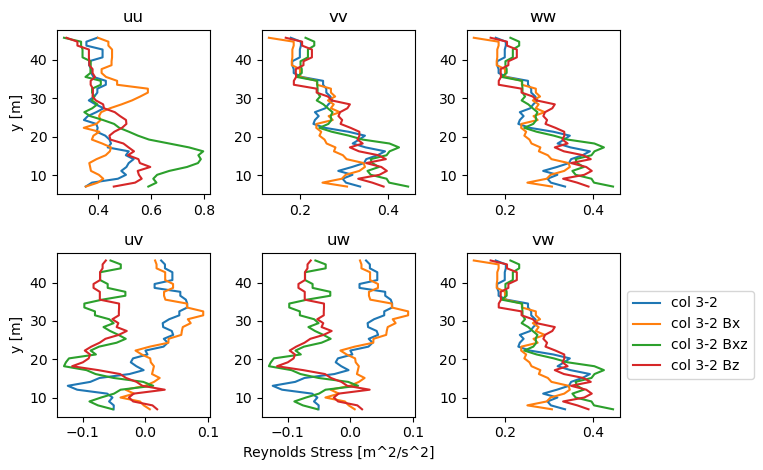

In [ ]:
quantities.plot_reynolds_stresses(qty_dict)

## Plot Turbulence Intensities

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='Iu', ylabel='y [m]'>, <Axes: xlabel='Iv'>,
        <Axes: xlabel='Iw'>], dtype=object))

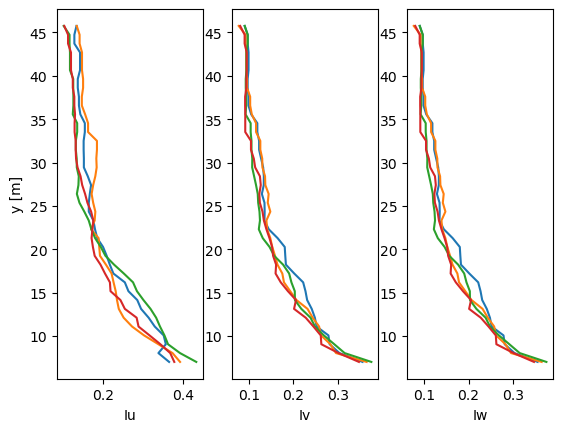

In [ ]:
quantities.plot_turbulence_intensities(qty_dict)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Prms [Pa]', ylabel='y [m]'>)

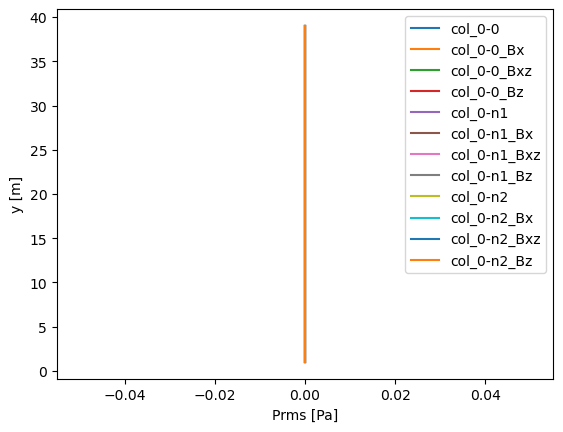

In [ ]:
quantities.plot_prms(qty_dict)

## Spectra

processing data took 2 seconds
pressure data not founnd, replacing with zeros
processing data took 1 seconds
pressure data not founnd, replacing with zeros


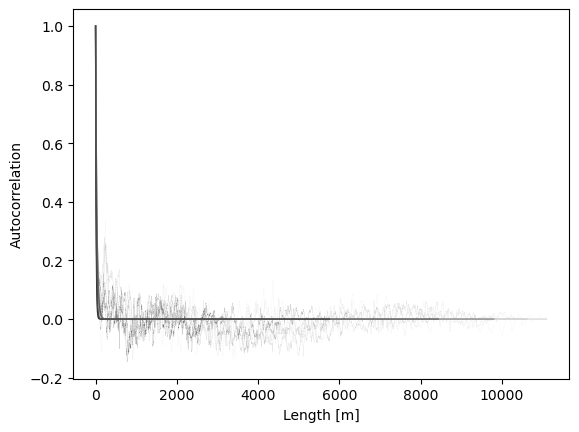

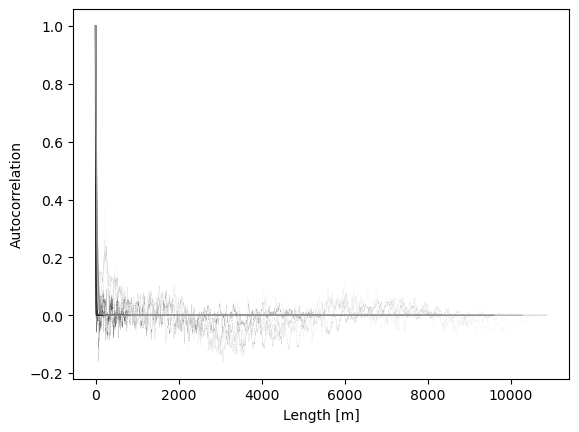

In [ ]:
stack = [1, 10, 20, 30, 40, 50]

qty_dict = probes.create_qty_dict(
    theta_wind = theta,
    names = [name for name in  probes.probe_names if "col" in name][0:2],#[name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    stack = stack,
)

for k, v in qty_dict.items(): v.calc_spectra()

/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/pyCascade/quantities.py:299: RuntimeWarning: divide by zero encountered in power
  ax.loglog(qty.f, initial_offset*qty.f**(eval(scaling)), label = scaling)


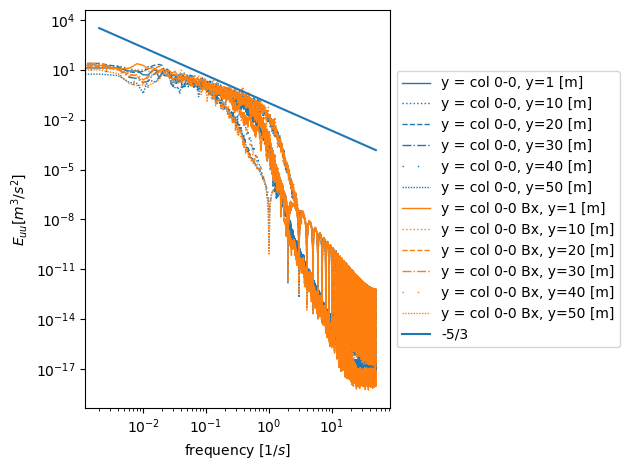

In [ ]:
fig, ax = quantities.plot_power_spectra(qty_dict, var = 'Euu')

## Plot p_rms


/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/pyCascade/quantities.py:299: RuntimeWarning: divide by zero encountered in reciprocal
  ax.loglog(qty.f, initial_offset*qty.f**(eval(scaling)), label = scaling)


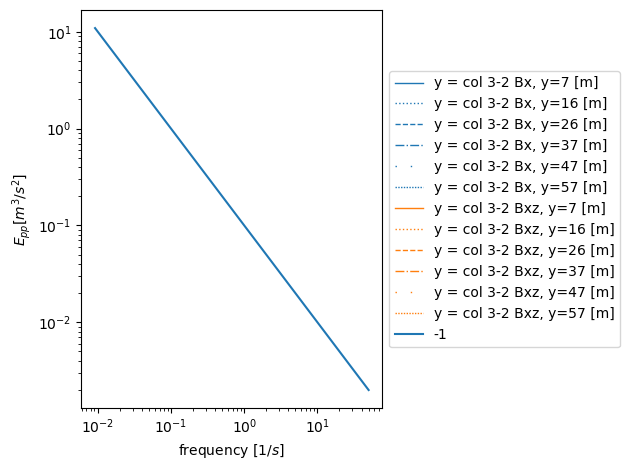

In [ ]:
fig, ax = quantities.plot_power_spectra(qty_dict, var = "Epp", scaling = "-1")